## Basic specialised models

In [11]:
import pandas as pd

In [12]:
industry_data_with_target = pd.read_csv('./industry_data_with_target.csv',sep='\t',low_memory=False)

In [13]:
industry_data_with_target = industry_data_with_target[industry_data_with_target['application_status_target']!=0]

In [14]:
# ───────────────────────────────
# 1.  SET-UP
# ───────────────────────────────
import re
import pandas as pd

df = industry_data_with_target.copy()
TARGET_COL = "application_status_target"     # positive / negative label
MIN_OBS_PER_CLASS = 30                       # feel free to tune

# ───────────────────────────────
# 2.  COLUMN DISCOVERY
# ───────────────────────────────
# keep *all* top1 columns – nothing else
top1_cols = [c for c in df.columns if c.startswith("top1_")]

# ───────────────────────────────
# 3.  PARSING HELPER
# ───────────────────────────────
# Matches strings like:
#   top1_isic_rev4_1
#   top1_isic_rev4_1_excl_service
#   top1_sitc_rev4_45
#   top1_naics07_3_excl_service
#
regex = re.compile(
    r"^top1_(?P<standard>.+?)_(?P<level>\d+)(?:_excl_service)?$"
)

def split_standard_and_level(colname: str) -> tuple[str, int]:
    m = regex.match(colname)
    if not m:
        raise ValueError(f"Unexpected column name format: {colname}")
    return m.group("standard"), int(m.group("level"))

# ───────────────────────────────
# 4.  GATHER STATS
# ───────────────────────────────
records = []

for col in top1_cols:
    standard, level = split_standard_and_level(col)
    
    # class counts (drop NaNs so they don’t form their own class)
    class_sizes = df[col].dropna().value_counts()
    
    n_classes            = len(class_sizes)
    min_size             = class_sizes.min()
    max_size             = class_sizes.max()
    mean_size            = round(class_sizes.mean(), 1)
    median_size          = class_sizes.median()
    std_size             = round(class_sizes.std(), 1)
    imbalance_ratio      = round(max_size / max(min_size, 1), 1)
    
    classes_big_enough   = (class_sizes >= MIN_OBS_PER_CLASS).sum()
    pct_big_enough       = round(classes_big_enough / n_classes * 100, 1)
    
    # label balance inside each class
    pos_rate_by_class    = (
        df[[col, TARGET_COL]]
        .dropna()
        .groupby(col)[TARGET_COL]
        .mean()
    )
    pos_rate_delta       = round(pos_rate_by_class.max() - pos_rate_by_class.min(), 3)
    
    records.append({
        "standard"             : standard,
        "level"                : level,
        "#classes"             : n_classes,
        "min size"             : min_size,
        "max size"             : max_size,
        "mean size"            : mean_size,
        "median size"          : median_size,
        "size std"             : std_size,
        "imbalance (max/min)"  : imbalance_ratio,
        f"% classes ≥ {MIN_OBS_PER_CLASS}" : pct_big_enough,
        "pos-rate Δ"           : pos_rate_delta,
        "column"               : col,               # for drilling down later
    })

feasibility_df = (
    pd.DataFrame(records)
      .sort_values(["standard", "level"])
      .reset_index(drop=True)
)

# ───────────────────────────────
# 5.  DISPLAY
# ───────────────────────────────
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(feasibility_df)


,standard,level,#classes,min size,max size,mean size,median size,size std,imbalance (max/min),% classes ≥ 30,pos-rate Δ,column
0,hs2007,1,11,851,249514,49316.5,28375.0,71887.0,293.2,100.0,0.761,top1_hs2007_1
1,hs2007,2,95,1,81655,5710.3,1374.0,13019.0,81655.0,92.6,1.395,top1_hs2007_2
2,hs2007,3,167,1,42842,3248.4,875.0,6555.3,42842.0,89.8,2.000,top1_hs2007_3
3,hs2007,4,619,1,21737,876.4,91.0,2322.3,21737.0,65.8,2.000,top1_hs2007_4
4,hs2007,5,837,1,22212,648.1,66.0,1844.8,22212.0,62.5,2.000,top1_hs2007_5
5,hs2007,6,852,1,22203,636.7,71.5,1824.3,22203.0,61.7,2.000,top1_hs2007_6
6,isic_rev4,1,8,846,387213,67810.1,16262.0,131324.6,457.7,100.0,0.677,top1_isic_rev4_1
7,isic_rev4,1,7,846,466181,77497.3,14166.0,171624.1,551.0,100.0,0.658,top1_isic_rev4_1_excl_service
8,isic_rev4,2,79,1,112887,6866.8,1050.0,15655.1,112887.0,88.6,2.000,top1_isic_rev4_2
9,isic_rev4,2,40,31,160278,13562.0,2686.0,26677.5,5170.3,100.0,0.875,top1_isic_rev4_2_excl_service


In [15]:
data = pd.read_csv('./joined_data_for_spec_model_training.csv',sep='\t')

In [16]:
feature_cols = ['srep_total_citations',
       'srep_patent_citation_count', 'srep_non_patent_citation_count',
       'srep_fraction_patent_citations', 'srep_citation_count_X',
       'srep_citation_count_Y', 'srep_citation_count_A',
       'srep_citation_count_D', 'srep_citation_count_E',
       'srep_citation_count_P', 'srep_citation_count_T',
       'fraction_claims_covered_by_>=1_X', 'fraction_claims_covered_by_>=2_X',
       'fraction_claims_covered_by_>=3_X', 'fraction_claims_covered_by_>=1_Y',
       'fraction_claims_covered_by_>=2_Y', 'fraction_claims_covered_by_>=3_Y',
       'fraction_claims_covered_by_>=1_A', 'fraction_claims_covered_by_>=2_A',
       'fraction_claims_covered_by_>=3_A', 'fraction_claims_covered_by_>=1_D',
       'fraction_claims_covered_by_>=2_D', 'fraction_claims_covered_by_>=3_D',
       'fraction_claims_covered_by_>=1_E', 'fraction_claims_covered_by_>=2_E',
       'fraction_claims_covered_by_>=3_E', 'fraction_claims_covered_by_>=1_P',
       'fraction_claims_covered_by_>=2_P', 'fraction_claims_covered_by_>=3_P',
       'fraction_claims_covered_by_>=1_T', 'fraction_claims_covered_by_>=2_T',
       'fraction_claims_covered_by_>=3_T', 'srep_unique_claims_cited',
       'srep_fraction_claims_cited', 'ref_total', 'ref_patent_count',
       'ref_non_patent_count', 'ref_fraction_patent', 'ref_found_count',
       'ref_fraction_found', 'fraction_applicant_refs_in_srep', 'is_no_unity',
       'is_incomplete_search', 'is_no_search', 'num_claims',
       'total_claims_tree_x', 'num_independent_claims_tree_x',
       'ratio_dep_to_total_claims_tree', 'max_depth_tree',
       'average_depth_tree', 'avg_branching_factor_tree',
       'max_branching_factor_tree', 'fraction_of_claims_cited',
       'fraction_of_independent_claims_cited',
       'fraction_of_dependent_claims_cited',
       'average_citations_per_cited_claim',
       'total_claims_tree_y', 'num_independent_claims_tree_y']

In [17]:
common_colls = set(data.columns).intersection(set(industry_data_with_target.columns))
full_data = pd.merge(data,industry_data_with_target,on=list(common_colls),how='inner')

In [18]:
# ─────────────────────────────────────────────────────────────────────────
# 0.  Imports (same as before)
# ─────────────────────────────────────────────────────────────────────────
import os, re
from pathlib import Path
from collections import defaultdict
from typing import Iterable, List, Dict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score

# ─────────────────────────────────────────────────────────────────────────
# 1.  Loader helpers (unchanged)
# ─────────────────────────────────────────────────────────────────────────
SUMMARY_DIR = "./Data/summary_statistics"
PERSON_PATH = {
    "applicant": f"{SUMMARY_DIR}/applicant_summary_statistics/"
                 "basic_applicant_summary_characteristics_cutoff_{year}.csv",
    "inventor":  f"{SUMMARY_DIR}/inventor_summary_statistics/"
                 "basic_inventor_summary_characteristics_cutoff_{year}.csv",
    "attorney":  f"{SUMMARY_DIR}/attorney_summary_statistics/"
                 "basic_attorney_summary_characteristics_cutoff_{year}.csv",
}


def _load_merged_df(df_patents: pd.DataFrame, year: int) -> pd.DataFrame:
    dfs = [
        pd.read_csv(path_tpl.format(year=year), sep="\t")
        for path_tpl in PERSON_PATH.values()
    ]
    person_df = dfs[0]
    for sub in dfs[1:]:
        person_df = person_df.merge(sub, on="application_number", how="outer")
    
    return (
        df_patents.merge(person_df,   on="application_number", how="left")
                  
    )

# ─────────────────────────────────────────────────────────────────────────
# 2.  Feasible split definitions
# ─────────────────────────────────────────────────────────────────────────
SPLITS = [
    {"prefix": "hs2007",    "max_lvl": 3, "excl": False},
    {"prefix": "isic_rev4", "max_lvl": 4, "excl": True },
    {"prefix": "naics07",   "max_lvl": 5, "excl": True },
    {"prefix": "sitc_rev4", "max_lvl": 3, "excl": False},
]


_RGX = re.compile(r"^top1_(?P<standard>.+?)_(?P<lvl>\d+)(?P<suffix>.*)$")

def _find_grouping_col(cols: Iterable[str], prefix: str, level: int, excl: bool) -> str:
    """
    Return the single column that defines the industry *class* for this split.
    Example:  ('hs2007', 3, False)  →  'top1_hs2007_3'
    """
    for c in cols:
        m = _RGX.match(c)
        if not m:
            continue
        std, lvl, suffix = m.group("standard"), int(m.group("lvl")), m.group("suffix")
        if std.startswith(prefix) and lvl == level:
            if excl and "_excl_service" not in suffix:
                continue
            if not excl and "_excl_service" in suffix:
                continue
            return c
    raise ValueError(f"No column found for {prefix} level {level} (excl={excl})")

# ─────────────────────────────────────────────────────────────────────────
# 3.  Categorical → numeric helper  (same as previous patch)
# ─────────────────────────────────────────────────────────────────────────
def _encode_frame(df_train: pd.DataFrame, df_test: pd.DataFrame):
    Xtr, Xte = df_train.copy(), df_test.copy()
    for col in Xtr.columns:
        tr_num = pd.to_numeric(Xtr[col], errors="coerce")
        if tr_num.notna().all():
            Xtr[col] = tr_num.astype(np.float32)
            Xte[col] = pd.to_numeric(Xte[col], errors="coerce").fillna(0).astype(np.float32)
            continue
        Xtr[col] = Xtr[col].fillna("Missing").astype("category")
        cats = Xtr[col].cat.categories
        Xtr[col] = Xtr[col].cat.codes.astype(np.int16)
        Xte[col] = (
            pd.Categorical(Xte[col].fillna("Missing"), categories=cats)
              .codes.astype(np.int16)
        )
    return Xtr, Xte

# ─────────────────────────────────────────────────────────────────────────
# 4.  Main routine: per-class training without industry features
# ─────────────────────────────────────────────────────────────────────────
def run_splits_grouped(
    df_patents: pd.DataFrame,
    *,
    target_col: str,
    base_feature_cols: List[str],
    cutoff_years: Iterable[int] = (2015, 2016, 2017, 2018, 2019),
    model_factory = lambda: DecisionTreeClassifier(random_state=0),
    min_train = 30,            # skip classes with <30 training rows
    min_test  = 15,            # skip classes with <15 test   rows
    verbose: bool = True,
):
    df_patents = df_patents.copy()
    df_patents["publication_date"] = pd.to_datetime(df_patents["publication_date"], errors="coerce")
    df_patents = df_patents[df_patents["publication_date"].dt.year <= 2020]

    joined_by_year = {yr: _load_merged_df(df_patents, yr) for yr in cutoff_years}

    details = defaultdict(list)


    # ───────── iterate split × level ─────────
    for sp in SPLITS:
        for lvl in range(1, sp["max_lvl"] + 1):
            split_name = f"{sp['prefix'].upper()} L{lvl}"
            if verbose: print(f"\n▶︎ Split: {split_name}")
            for yr in cutoff_years:
                df_year = joined_by_year[yr]

                train_mask = df_year["publication_date"].dt.year <= yr
                df_train, df_test = df_year[train_mask], df_year[~train_mask]
                if df_train.empty or df_test.empty:
                    if verbose: print(f"  • {yr}: skipped (empty train/test).")
                    continue

                group_col = _find_grouping_col(
                    df_year.columns,
                    prefix = sp["prefix"],
                    level  = lvl,
                    excl   = sp["excl"],
                )

                # ─ per-class loop ──────────────────────────────────────────
                w_acc = w_f1 = total_test = 0
                n_models = 0
                skipped_test_rows = 0
                skipped_train_idx = pd.Series(False, index=df_train.index)
                skipped_test_idx  = pd.Series(False, index=df_test.index)

                for cls in df_train[group_col].dropna().unique():
                    tr_idx = df_train[group_col] == cls
                    te_idx = df_test [group_col] == cls

                    n_tr, n_te = tr_idx.sum(), te_idx.sum()
                    if n_tr < min_train or n_te < min_test:
                        skipped_train_idx |= tr_idx
                        skipped_test_idx  |= te_idx
                        skipped_test_rows += n_te
                        continue

                    # feature build (same logic as before)
                    person_cols = [
                        c for c in df_year.columns
                        if c not in base_feature_cols
                        and not c.startswith("top")
                        and c not in {"application_number","publication_date",target_col,group_col}
                    ]
                    feature_cols = base_feature_cols + person_cols

                    X_tr_raw, X_te_raw = (
                        df_train.loc[tr_idx, feature_cols],
                        df_test .loc[te_idx, feature_cols],
                    )
                    X_tr, X_te = _encode_frame(X_tr_raw, X_te_raw)
                    y_tr, y_te = df_train.loc[tr_idx, target_col], df_test.loc[te_idx, target_col]

                    clf = model_factory()
                    clf.fit(X_tr, y_tr)
                    y_pred = clf.predict(X_te)

                    acc = accuracy_score(y_te, y_pred)
                    f1  = f1_score     (y_te, y_pred, zero_division=0)

                    w_acc      += acc * n_te
                    w_f1       += f1  * n_te
                    total_test += n_te
                    n_models   += 1

                # ─ fallback model for “no-class” rows ────────────────────
                if skipped_test_rows:
                    X_tr_raw, X_te_raw = (
                        df_train.loc[skipped_train_idx, feature_cols],
                        df_test .loc[skipped_test_idx,  feature_cols],
                    )
                    y_tr, y_te = (
                        df_train.loc[skipped_train_idx, target_col],
                        df_test .loc[skipped_test_idx,  target_col],
                    )
                    if len(y_tr) >= min_train and len(y_te) >= min_test:
                        X_tr, X_te = _encode_frame(X_tr_raw, X_te_raw)
                        clf = model_factory()
                        clf.fit(X_tr, y_tr)
                        y_pred = clf.predict(X_te)
                        acc_fb = accuracy_score(y_te, y_pred)
                        f1_fb  = f1_score     (y_te, y_pred, zero_division=0)

                        w_acc      += acc_fb * len(y_te)
                        w_f1       += f1_fb  * len(y_te)
                        total_test += len(y_te)
                        n_models   += 1      # counts as an extra model
                        if verbose:
                            print(f"    ↳ Fallback model  acc={acc_fb:.3f}  "
                                  f"f1={f1_fb:.3f}  (rows={len(y_te)})")

                if total_test == 0:
                    if verbose: print(f"  • {yr}: no class met thresholds.")
                    continue

                details[split_name].append({
                    "year"            : yr,
                    "models"          : n_models,
                    "skipped_test"    : skipped_test_rows,
                    "test_size"       : total_test,
                    "accuracy"        : w_acc / total_test,
                    "f1"              : w_f1  / total_test,
                })

                if verbose:
                    print(f"  • {yr}: {n_models} models "
                          f"(skipped rows = {skipped_test_rows}) → "
                          f"acc={w_acc/total_test:.3f}  f1={w_f1/total_test:.3f}")
    # ─ summary by split ───────────────────────────────────────────────────
    rows = []
    for name, stats in details.items():
        w = np.array([s["test_size"] for s in stats], dtype=float)
        accs = np.array([s["accuracy"] for s in stats])
        f1s  = np.array([s["f1"]       for s in stats])
        rows.append({
            "split"            : name,
            "years_run"        : len(stats),
            "weighted_accuracy": np.average(accs, weights=w),
            "weighted_f1"      : np.average(f1s,  weights=w),
        })

    summary_df = (
        pd.DataFrame(rows)
          .sort_values("weighted_accuracy", ascending=False)
          .reset_index(drop=True)
    )
    return summary_df, details



▶︎ Split: HS2007 L1
  • 2015: 11 models (skipped rows = 0) → acc=0.353  f1=0.203
  • 2016: 11 models (skipped rows = 0) → acc=0.376  f1=0.266
  • 2017: 11 models (skipped rows = 0) → acc=0.387  f1=0.297
  • 2018: 11 models (skipped rows = 0) → acc=0.394  f1=0.308
  • 2019: 11 models (skipped rows = 0) → acc=0.398  f1=0.327

▶︎ Split: HS2007 L2
    ↳ Fallback model  acc=0.370  f1=0.033  (rows=281)
  • 2015: 82 models (skipped rows = 281) → acc=0.334  f1=0.140
    ↳ Fallback model  acc=0.344  f1=0.019  (rows=157)
  • 2016: 84 models (skipped rows = 157) → acc=0.349  f1=0.192
    ↳ Fallback model  acc=0.569  f1=0.562  (rows=65)
  • 2017: 86 models (skipped rows = 65) → acc=0.368  f1=0.246
    ↳ Fallback model  acc=0.507  f1=0.227  (rows=69)
  • 2018: 84 models (skipped rows = 69) → acc=0.374  f1=0.260
    ↳ Fallback model  acc=0.458  f1=0.416  (rows=83)
  • 2019: 78 models (skipped rows = 83) → acc=0.384  f1=0.298

▶︎ Split: HS2007 L3
    ↳ Fallback model  acc=0.366  f1=0.063  (rows=702)

,split,years_run,weighted_accuracy,weighted_f1
0,NAICS07 L1,5,0.381765,0.281683
1,ISIC_REV4 L1,5,0.380829,0.279402
2,NAICS07 L2,5,0.378677,0.271450
3,HS2007 L1,5,0.374243,0.260153
4,SITC_REV4 L1,5,0.372727,0.255828
5,NAICS07 L3,5,0.364531,0.230061
6,ISIC_REV4 L2,5,0.357580,0.214964
7,SITC_REV4 L2,5,0.355014,0.208643
8,HS2007 L2,5,0.353442,0.200502
9,HS2007 L3,5,0.353110,0.200803


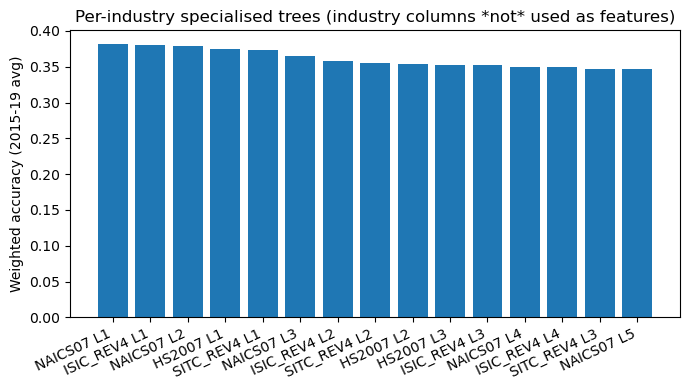

In [42]:
summary, per_year = run_splits_grouped(
    full_data,
    target_col="application_status_target",
    base_feature_cols=feature_cols,
    verbose=True,
)

print("\n=====  SUMMARY  =====")
display(summary)

# ─–––– simple bar chart (top-4, because we have 4 splits) –––––
plt.figure(figsize=(7,4))
plt.bar(summary["split"], summary["weighted_accuracy"])
plt.ylabel("Weighted accuracy (2015-19 avg)")
plt.title("Per-industry specialised trees (industry columns *not* used as features)")
plt.xticks(rotation=25, ha='right')
plt.tight_layout()
plt.show()

In [40]:
full_data["publication_date"] = pd.to_datetime(full_data["publication_date"], errors="coerce")
test_sample = full_data[full_data['publication_date'].dt.yr>=2019]

AttributeError: 'DatetimeProperties' object has no attribute 'yr'

## Ensemble Model

In [28]:
# ─────────────────────────────────────────────────────────────────────────
# 5.  One-year run (2019) + majority-vote ensemble
# ─────────────────────────────────────────────────────────────────────────
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def run_splits_grouped_with_ensemble(
    df_patents: pd.DataFrame,
    *,
    target_col: str,
    base_feature_cols: List[str],
    year: int = 2019,
    model_factory = lambda: DecisionTreeClassifier(random_state=0),
    min_train: int = 30,
    min_test : int = 15,
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Returns
    -------
    split_preds : DataFrame
        Index = test-set rows, columns = “[STD]_Lx” votes (-1 / +1 / 0).
    ensemble_df : DataFrame
        [application_number, truth, vote_sum, ensemble_pred] for the 2019 test set.
    """
    # ─── 1.  prepare data  ───────────────────────────────────────────────
    df_patents = df_patents.copy()
    df_patents["publication_date"] = pd.to_datetime(
        df_patents["publication_date"], errors="coerce"
    )
    df_year = _load_merged_df(df_patents, year)

    train_mask = df_year["publication_date"].dt.year <= year
    df_train, df_test = df_year[train_mask], df_year[~train_mask]
    if df_test.empty:
        raise ValueError("No 2019-split test rows found.")

    split_preds = pd.DataFrame(index=df_test.index)  # will be filled column-wise

    # ─── 2.  iterate over industry splits / levels  ──────────────────────
    for sp in SPLITS:
        for lvl in range(1, sp["max_lvl"] + 1):
            col_name   = f"{sp['prefix'].upper()}_L{lvl}"
            group_col  = _find_grouping_col(
                df_year.columns,
                prefix = sp["prefix"],
                level  = lvl,
                excl   = sp["excl"],
            )

            # start with “neutral” (=0) vote for every row
            col_pred = pd.Series(0, index=df_test.index, dtype=int)

            # per-class specialised models
            for cls in df_train[group_col].dropna().unique():
                tr_idx = df_train[group_col] == cls
                te_idx = df_test [group_col] == cls

                n_tr, n_te = tr_idx.sum(), te_idx.sum()
                if n_tr < min_train or n_te < min_test:
                    continue

                # feature build
                person_cols = [
                    c for c in df_year.columns
                    if c not in base_feature_cols
                    and not c.startswith("top")
                    and c not in {
                        "application_number", "publication_date",
                        target_col, group_col
                    }
                ]
                feature_cols = base_feature_cols + person_cols

                X_tr_raw, X_te_raw = (
                    df_train.loc[tr_idx, feature_cols],
                    df_test .loc[te_idx, feature_cols],
                )
                X_tr, X_te = _encode_frame(X_tr_raw, X_te_raw)
                y_tr = df_train.loc[tr_idx, target_col]

                clf = model_factory()
                clf.fit(X_tr, y_tr)
                col_pred.loc[te_idx] = clf.predict(X_te).astype(int)

            # fallback for any rows still at 0
            mask_unpred = col_pred == 0
            if mask_unpred.any():
                tr_idx_fb = df_train[group_col].isna()
                te_idx_fb = df_test [group_col].isna() & mask_unpred
                if tr_idx_fb.sum() >= min_train and te_idx_fb.sum() >= min_test:
                    X_tr_raw, X_te_raw = (
                        df_train.loc[tr_idx_fb, feature_cols],
                        df_test .loc[te_idx_fb, feature_cols],
                    )
                    X_tr, X_te = _encode_frame(X_tr_raw, X_te_raw)
                    y_tr_fb = df_train.loc[tr_idx_fb, target_col]

                    clf_fb = model_factory()
                    clf_fb.fit(X_tr, y_tr_fb)
                    col_pred.loc[te_idx_fb] = clf_fb.predict(X_te).astype(int)

            split_preds[col_name] = col_pred

    # ─── 3.  Majority-vote ensemble  ─────────────────────────────────────
    vote_sum = split_preds.sum(axis=1)
    ensemble_pred = (vote_sum >= 0).astype(int)         # 1 if ≥0 else 0

    ensemble_df = pd.DataFrame({
        "application_number": df_test["application_number"],
        "truth"             : df_test[target_col],
        "vote_sum"          : vote_sum,
        "ensemble_pred"     : ensemble_pred,
    }, index=df_test.index)

    # optional quick metrics
    acc = accuracy_score(ensemble_df["truth"], ensemble_df["ensemble_pred"])
    f1  = f1_score     (ensemble_df["truth"], ensemble_df["ensemble_pred"],
                        zero_division=0, average="binary", pos_label=1)
    print(f"Ensemble 2019 — acc={acc:.3f}  f1={f1:.3f}")

    # save to disk
    split_preds.to_csv("split_preds_2019.csv")
    ensemble_df.to_csv("ensemble_preds_2019.csv", index=False)
    print("⇢ saved  split_preds_2019.csv  and  ensemble_preds_2019.csv")

    return split_preds, ensemble_df


In [29]:
split_preds_2019, ensemble_2019 = run_splits_grouped_with_ensemble(
    df_patents           = full_data,           # your main DataFrame
    target_col           = "application_status_target",
    base_feature_cols    = feature_cols,        # your core features
)

ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

## Visuelisations: 

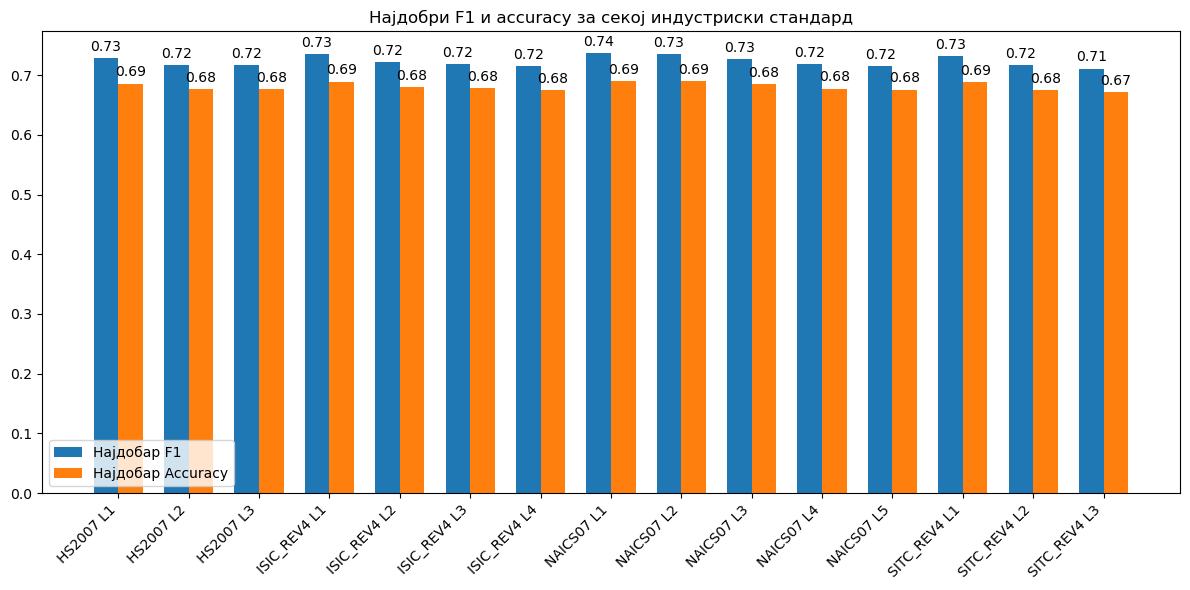

In [9]:
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

# -----------------------
# Assume you already have your big defaultdict called `results`:
# For demonstration, I'll show how to process it assuming it's named `results`.
# -----------------------

# Example: plug your big defaultdict in this variable:
results = defaultdict(list,
            {'HS2007 L1': [{'year': 2015,
               'models': 10,
               'skipped_test': np.int64(357),
               'test_size': np.int64(328585),
               'accuracy': np.float64(0.43210432612566),
               'f1': np.float64(0.3419908494776196)},
              {'year': 2016,
               'models': 11,
               'skipped_test': 0,
               'test_size': np.int64(275234),
               'accuracy': np.float64(0.46833240079350663),
               'f1': np.float64(0.4206609047070266)},
              {'year': 2017,
               'models': 11,
               'skipped_test': 0,
               'test_size': np.int64(219544),
               'accuracy': np.float64(0.5303583791859491),
               'f1': np.float64(0.5285113156455493)},
              {'year': 2018,
               'models': 11,
               'skipped_test': 0,
               'test_size': np.int64(160954),
               'accuracy': np.float64(0.5920325061818905),
               'f1': np.float64(0.6179039375497978)},
              {'year': 2019,
               'models': 11,
               'skipped_test': 0,
               'test_size': np.int64(105620),
               'accuracy': np.float64(0.6858076121946601),
               'f1': np.float64(0.7286659898824921)}],
             'HS2007 L2': [{'year': 2015,
               'models': 79,
               'skipped_test': np.int64(813),
               'test_size': np.int64(328942),
               'accuracy': np.float64(0.4268351259492555),
               'f1': np.float64(0.3280002609808781)},
              {'year': 2016,
               'models': 82,
               'skipped_test': np.int64(281),
               'test_size': np.int64(275234),
               'accuracy': np.float64(0.46932065079169),
               'f1': np.float64(0.42103972805537676)},
              {'year': 2017,
               'models': 84,
               'skipped_test': np.int64(157),
               'test_size': np.int64(219544),
               'accuracy': np.float64(0.5183607841708268),
               'f1': np.float64(0.5054983784805614)},
              {'year': 2018,
               'models': 86,
               'skipped_test': np.int64(65),
               'test_size': np.int64(160954),
               'accuracy': np.float64(0.5754439156529194),
               'f1': np.float64(0.5914772711565452)},
              {'year': 2019,
               'models': 84,
               'skipped_test': np.int64(69),
               'test_size': np.int64(105620),
               'accuracy': np.float64(0.6767184245408067),
               'f1': np.float64(0.7175344723677569)}],
             'HS2007 L3': [{'year': 2015,
               'models': 128,
               'skipped_test': np.int64(1533),
               'test_size': np.int64(328922),
               'accuracy': np.float64(0.4350362699971422),
               'f1': np.float64(0.34143155427108596)},
              {'year': 2016,
               'models': 135,
               'skipped_test': np.int64(702),
               'test_size': np.int64(275234),
               'accuracy': np.float64(0.4717840092430441),
               'f1': np.float64(0.4267792262640259)},
              {'year': 2017,
               'models': 141,
               'skipped_test': np.int64(279),
               'test_size': np.int64(219544),
               'accuracy': np.float64(0.522578617498087),
               'f1': np.float64(0.5129786934304786)},
              {'year': 2018,
               'models': 145,
               'skipped_test': np.int64(123),
               'test_size': np.int64(160954),
               'accuracy': np.float64(0.5762578127912322),
               'f1': np.float64(0.5924724752228155)},
              {'year': 2019,
               'models': 137,
               'skipped_test': np.int64(172),
               'test_size': np.int64(105620),
               'accuracy': np.float64(0.6760935428896042),
               'f1': np.float64(0.7165445429024999)}],
             'ISIC_REV4 L1': [{'year': 2015,
               'models': 6,
               'skipped_test': np.int64(352),
               'test_size': np.int64(328590),
               'accuracy': np.float64(0.42219178915974315),
               'f1': np.float64(0.3202477647187265)},
              {'year': 2016,
               'models': 7,
               'skipped_test': 0,
               'test_size': np.int64(275234),
               'accuracy': np.float64(0.49912438143543314),
               'f1': np.float64(0.482111535864429)},
              {'year': 2017,
               'models': 7,
               'skipped_test': 0,
               'test_size': np.int64(219544),
               'accuracy': np.float64(0.5431895200961994),
               'f1': np.float64(0.5504325681577967)},
              {'year': 2018,
               'models': 7,
               'skipped_test': 0,
               'test_size': np.int64(160954),
               'accuracy': np.float64(0.5915230438510382),
               'f1': np.float64(0.6195670804636604)},
              {'year': 2019,
               'models': 7,
               'skipped_test': 0,
               'test_size': np.int64(105620),
               'accuracy': np.float64(0.689102442719182),
               'f1': np.float64(0.7347636536543539)}],
             'ISIC_REV4 L2': [{'year': 2015,
               'models': 38,
               'skipped_test': np.int64(412),
               'test_size': np.int64(328942),
               'accuracy': np.float64(0.4335445154464921),
               'f1': np.float64(0.33826738972000603)},
              {'year': 2016,
               'models': 39,
               'skipped_test': np.int64(52),
               'test_size': np.int64(275234),
               'accuracy': np.float64(0.4814921121663748),
               'f1': np.float64(0.4446292914429814)},
              {'year': 2017,
               'models': 39,
               'skipped_test': np.int64(12),
               'test_size': np.int64(219532),
               'accuracy': np.float64(0.5229624838292367),
               'f1': np.float64(0.5167290228980694)},
              {'year': 2018,
               'models': 39,
               'skipped_test': np.int64(8),
               'test_size': np.int64(160946),
               'accuracy': np.float64(0.5820834317100145),
               'f1': np.float64(0.6040426416704825)},
              {'year': 2019,
               'models': 38,
               'skipped_test': np.int64(14),
               'test_size': np.int64(105606),
               'accuracy': np.float64(0.6795352536787682),
               'f1': np.float64(0.7216321929094853)}],
             'ISIC_REV4 L3': [{'year': 2015,
               'models': 86,
               'skipped_test': np.int64(843),
               'test_size': np.int64(328935),
               'accuracy': np.float64(0.43214920881025126),
               'f1': np.float64(0.3402252251200062)},
              {'year': 2016,
               'models': 90,
               'skipped_test': np.int64(252),
               'test_size': np.int64(275233),
               'accuracy': np.float64(0.4741764250653083),
               'f1': np.float64(0.43278970264673833)},
              {'year': 2017,
               'models': 91,
               'skipped_test': np.int64(165),
               'test_size': np.int64(219543),
               'accuracy': np.float64(0.5196430767548954),
               'f1': np.float64(0.5101444336386383)},
              {'year': 2018,
               'models': 91,
               'skipped_test': np.int64(128),
               'test_size': np.int64(160953),
               'accuracy': np.float64(0.575919678415438),
               'f1': np.float64(0.5930992669906314)},
              {'year': 2019,
               'models': 91,
               'skipped_test': np.int64(85),
               'test_size': np.int64(105619),
               'accuracy': np.float64(0.6783249225991536),
               'f1': np.float64(0.7192294219548842)}],
             'ISIC_REV4 L4': [{'year': 2015,
               'models': 130,
               'skipped_test': np.int64(1461),
               'test_size': np.int64(328931),
               'accuracy': np.float64(0.4337353426706513),
               'f1': np.float64(0.3450837204276583)},
              {'year': 2016,
               'models': 137,
               'skipped_test': np.int64(587),
               'test_size': np.int64(275225),
               'accuracy': np.float64(0.4704550822054683),
               'f1': np.float64(0.42537283062484876)},
              {'year': 2017,
               'models': 138,
               'skipped_test': np.int64(418),
               'test_size': np.int64(219536),
               'accuracy': np.float64(0.51754154216165),
               'f1': np.float64(0.5061143183583264)},
              {'year': 2018,
               'models': 141,
               'skipped_test': np.int64(253),
               'test_size': np.int64(160953),
               'accuracy': np.float64(0.5737451305660659),
               'f1': np.float64(0.5895732441014484)},
              {'year': 2019,
               'models': 140,
               'skipped_test': np.int64(197),
               'test_size': np.int64(105619),
               'accuracy': np.float64(0.6751058048267831),
               'f1': np.float64(0.71532692127547)}],
             'NAICS07 L1': [{'year': 2015,
               'models': 3,
               'skipped_test': np.int64(352),
               'test_size': np.int64(328590),
               'accuracy': np.float64(0.4198180102863751),
               'f1': np.float64(0.3146151039987178)},
              {'year': 2016,
               'models': 4,
               'skipped_test': 0,
               'test_size': np.int64(275234),
               'accuracy': np.float64(0.4998873685663835),
               'f1': np.float64(0.4838434653588811)},
              {'year': 2017,
               'models': 4,
               'skipped_test': 0,
               'test_size': np.int64(219544),
               'accuracy': np.float64(0.5423650839922749),
               'f1': np.float64(0.5500821414125439)},
              {'year': 2018,
               'models': 4,
               'skipped_test': 0,
               'test_size': np.int64(160954),
               'accuracy': np.float64(0.5940517166395367),
               'f1': np.float64(0.6213184405008699)},
              {'year': 2019,
               'models': 4,
               'skipped_test': 0,
               'test_size': np.int64(105620),
               'accuracy': np.float64(0.6905320961939027),
               'f1': np.float64(0.7363098700283872)}],
             'NAICS07 L2': [{'year': 2015,
               'models': 7,
               'skipped_test': np.int64(352),
               'test_size': np.int64(328590),
               'accuracy': np.float64(0.41975105754892117),
               'f1': np.float64(0.31392877842529016)},
              {'year': 2016,
               'models': 8,
               'skipped_test': 0,
               'test_size': np.int64(275234),
               'accuracy': np.float64(0.49835412776037846),
               'f1': np.float64(0.4800229827510648)},
              {'year': 2017,
               'models': 8,
               'skipped_test': 0,
               'test_size': np.int64(219544),
               'accuracy': np.float64(0.5421054549429727),
               'f1': np.float64(0.5483104329610098)},
              {'year': 2018,
               'models': 8,
               'skipped_test': 0,
               'test_size': np.int64(160954),
               'accuracy': np.float64(0.592778060812406),
               'f1': np.float64(0.6191827384822511)},
              {'year': 2019,
               'models': 8,
               'skipped_test': 0,
               'test_size': np.int64(105620),
               'accuracy': np.float64(0.6903900776368113),
               'f1': np.float64(0.7348002836895073)}],
             'NAICS07 L3': [{'year': 2015,
               'models': 33,
               'skipped_test': np.int64(378),
               'test_size': np.int64(328942),
               'accuracy': np.float64(0.43308850800445065),
               'f1': np.float64(0.3395977213097234)},
              {'year': 2016,
               'models': 33,
               'skipped_test': np.int64(23),
               'test_size': np.int64(275211),
               'accuracy': np.float64(0.48094371227894234),
               'f1': np.float64(0.4412758476076996)},
              {'year': 2017,
               'models': 33,
               'skipped_test': np.int64(20),
               'test_size': np.int64(219524),
               'accuracy': np.float64(0.5289444434321532),
               'f1': np.float64(0.5209065203705274)},
              {'year': 2018,
               'models': 33,
               'skipped_test': np.int64(16),
               'test_size': np.int64(160938),
               'accuracy': np.float64(0.5837838173706644),
               'f1': np.float64(0.6055677332811016)},
              {'year': 2019,
               'models': 33,
               'skipped_test': np.int64(7),
               'test_size': np.int64(105613),
               'accuracy': np.float64(0.6847357806330661),
               'f1': np.float64(0.7272141985725312)}],
             'NAICS07 L4': [{'year': 2015,
               'models': 90,
               'skipped_test': np.int64(1180),
               'test_size': np.int64(328931),
               'accuracy': np.float64(0.43177140494511007),
               'f1': np.float64(0.33708503648550775)},
              {'year': 2016,
               'models': 94,
               'skipped_test': np.int64(579),
               'test_size': np.int64(275233),
               'accuracy': np.float64(0.4720327867661218),
               'f1': np.float64(0.42560096271142445)},
              {'year': 2017,
               'models': 98,
               'skipped_test': np.int64(299),
               'test_size': np.int64(219543),
               'accuracy': np.float64(0.5172289710899459),
               'f1': np.float64(0.5053085618339422)},
              {'year': 2018,
               'models': 98,
               'skipped_test': np.int64(248),
               'test_size': np.int64(160953),
               'accuracy': np.float64(0.5723285679670462),
               'f1': np.float64(0.5872063392587936)},
              {'year': 2019,
               'models': 98,
               'skipped_test': np.int64(166),
               'test_size': np.int64(105619),
               'accuracy': np.float64(0.6773970592412351),
               'f1': np.float64(0.717857245859254)}],
             'NAICS07 L5': [{'year': 2015,
               'models': 138,
               'skipped_test': np.int64(2014),
               'test_size': np.int64(328902),
               'accuracy': np.float64(0.4306389137189801),
               'f1': np.float64(0.33573801770941536)},
              {'year': 2016,
               'models': 148,
               'skipped_test': np.int64(939),
               'test_size': np.int64(275222),
               'accuracy': np.float64(0.4690831401559468),
               'f1': np.float64(0.42195256914227675)},
              {'year': 2017,
               'models': 155,
               'skipped_test': np.int64(482),
               'test_size': np.int64(219534),
               'accuracy': np.float64(0.5159018648592018),
               'f1': np.float64(0.5012944123339564)},
              {'year': 2018,
               'models': 156,
               'skipped_test': np.int64(355),
               'test_size': np.int64(160948),
               'accuracy': np.float64(0.5739431369137858),
               'f1': np.float64(0.5887177876401704)},
              {'year': 2019,
               'models': 153,
               'skipped_test': np.int64(258),
               'test_size': np.int64(105616),
               'accuracy': np.float64(0.6757688229056203),
               'f1': np.float64(0.7154845415755289)}],
             'SITC_REV4 L1': [{'year': 2015,
               'models': 10,
               'skipped_test': np.int64(357),
               'test_size': np.int64(328585),
               'accuracy': np.float64(0.4377071381834229),
               'f1': np.float64(0.355323906151812)},
              {'year': 2016,
               'models': 11,
               'skipped_test': 0,
               'test_size': np.int64(275234),
               'accuracy': np.float64(0.4904226948705465),
               'f1': np.float64(0.4644035364891687)},
              {'year': 2017,
               'models': 11,
               'skipped_test': 0,
               'test_size': np.int64(219544),
               'accuracy': np.float64(0.5338428743213206),
               'f1': np.float64(0.5354218617996778)},
              {'year': 2018,
               'models': 11,
               'skipped_test': 0,
               'test_size': np.int64(160954),
               'accuracy': np.float64(0.5898952495744125),
               'f1': np.float64(0.6156258802345365)},
              {'year': 2019,
               'models': 11,
               'skipped_test': 0,
               'test_size': np.int64(105620),
               'accuracy': np.float64(0.6883639462223063),
               'f1': np.float64(0.7320849799198537)}],
             'SITC_REV4 L2': [{'year': 2015,
               'models': 58,
               'skipped_test': np.int64(800),
               'test_size': np.int64(328942),
               'accuracy': np.float64(0.43506150020368334),
               'f1': np.float64(0.34601410435196667)},
              {'year': 2016,
               'models': 62,
               'skipped_test': np.int64(157),
               'test_size': np.int64(275234),
               'accuracy': np.float64(0.47911595224427217),
               'f1': np.float64(0.44153991933702125)},
              {'year': 2017,
               'models': 64,
               'skipped_test': np.int64(24),
               'test_size': np.int64(219520),
               'accuracy': np.float64(0.5221847667638484),
               'f1': np.float64(0.515240455138331)},
              {'year': 2018,
               'models': 64,
               'skipped_test': np.int64(32),
               'test_size': np.int64(160954),
               'accuracy': np.float64(0.5728220485356065),
               'f1': np.float64(0.5881830647220653)},
              {'year': 2019,
               'models': 64,
               'skipped_test': np.int64(22),
               'test_size': np.int64(105620),
               'accuracy': np.float64(0.6755160007574323),
               'f1': np.float64(0.716225233774908)}],
             'SITC_REV4 L3': [{'year': 2015,
               'models': 159,
               'skipped_test': np.int64(2391),
               'test_size': np.int64(328917),
               'accuracy': np.float64(0.4334132927151835),
               'f1': np.float64(0.3430528312692999)},
              {'year': 2016,
               'models': 176,
               'skipped_test': np.int64(895),
               'test_size': np.int64(275215),
               'accuracy': np.float64(0.4662100539578148),
               'f1': np.float64(0.41420893639911044)},
              {'year': 2017,
               'models': 181,
               'skipped_test': np.int64(592),
               'test_size': np.int64(219536),
               'accuracy': np.float64(0.5165758691057503),
               'f1': np.float64(0.5031447392673506)},
              {'year': 2018,
               'models': 186,
               'skipped_test': np.int64(325),
               'test_size': np.int64(160952),
               'accuracy': np.float64(0.5688093344599632),
               'f1': np.float64(0.5810515540207537)},
              {'year': 2019,
               'models': 178,
               'skipped_test': np.int64(327),
               'test_size': np.int64(105618),
               'accuracy': np.float64(0.6716374102899128),
               'f1': np.float64(0.7110212272612283)}]})
# For testing, you can paste your big dict here directly.

# -----------------------
# 1) Extract best F1 and Accuracy per standard
# -----------------------

best_metrics = {}  # { standard: (best_f1, best_acc) }

for standard, yearly_results in results.items():
    max_f1 = max(item['f1'] for item in yearly_results)
    max_acc = max(item['accuracy'] for item in yearly_results)
    best_metrics[standard] = (max_f1, max_acc)

# -----------------------
# 2) Prepare data for plotting
# -----------------------

standards = list(best_metrics.keys())
best_f1 = [best_metrics[s][0] for s in standards]
best_acc = [best_metrics[s][1] for s in standards]

x = np.arange(len(standards))  # positions

# -----------------------
# 3) Plot bar chart
# -----------------------

width = 0.35  # width of each bar

fig, ax = plt.subplots(figsize=(12, 6))

# Bars for F1
bars1 = ax.bar(x - width/2, best_f1, width, label='Најдобар F1')

# Bars for Accuracy
bars2 = ax.bar(x + width/2, best_acc, width, label='Најдобар Accuracy')

# Labels & ticks
ax.set_ylabel('')
ax.set_title('Најдобри F1 и accuracy за секој индустриски стандард')
ax.set_xticks(x)
ax.set_xticklabels(standards, rotation=45, ha='right')
ax.legend()

# Annotate bars with values
def annotate_bars(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

annotate_bars(bars1)
annotate_bars(bars2)

plt.tight_layout()
plt.show()



Best F1 and Accuracy + years per standard:

HS2007 L1:
  Best F1: 0.7287 (Year(s): [2019])
  Best Accuracy: 0.6858 (Year(s): [2019])

HS2007 L2:
  Best F1: 0.7175 (Year(s): [2019])
  Best Accuracy: 0.6767 (Year(s): [2019])

HS2007 L3:
  Best F1: 0.7165 (Year(s): [2019])
  Best Accuracy: 0.6761 (Year(s): [2019])

ISIC_REV4 L1:
  Best F1: 0.7348 (Year(s): [2019])
  Best Accuracy: 0.6891 (Year(s): [2019])

ISIC_REV4 L2:
  Best F1: 0.7216 (Year(s): [2019])
  Best Accuracy: 0.6795 (Year(s): [2019])

ISIC_REV4 L3:
  Best F1: 0.7192 (Year(s): [2019])
  Best Accuracy: 0.6783 (Year(s): [2019])

ISIC_REV4 L4:
  Best F1: 0.7153 (Year(s): [2019])
  Best Accuracy: 0.6751 (Year(s): [2019])

NAICS07 L1:
  Best F1: 0.7363 (Year(s): [2019])
  Best Accuracy: 0.6905 (Year(s): [2019])

NAICS07 L2:
  Best F1: 0.7348 (Year(s): [2019])
  Best Accuracy: 0.6904 (Year(s): [2019])

NAICS07 L3:
  Best F1: 0.7272 (Year(s): [2019])
  Best Accuracy: 0.6847 (Year(s): [2019])

NAICS07 L4:
  Best F1: 0.7179 (Year(s): 

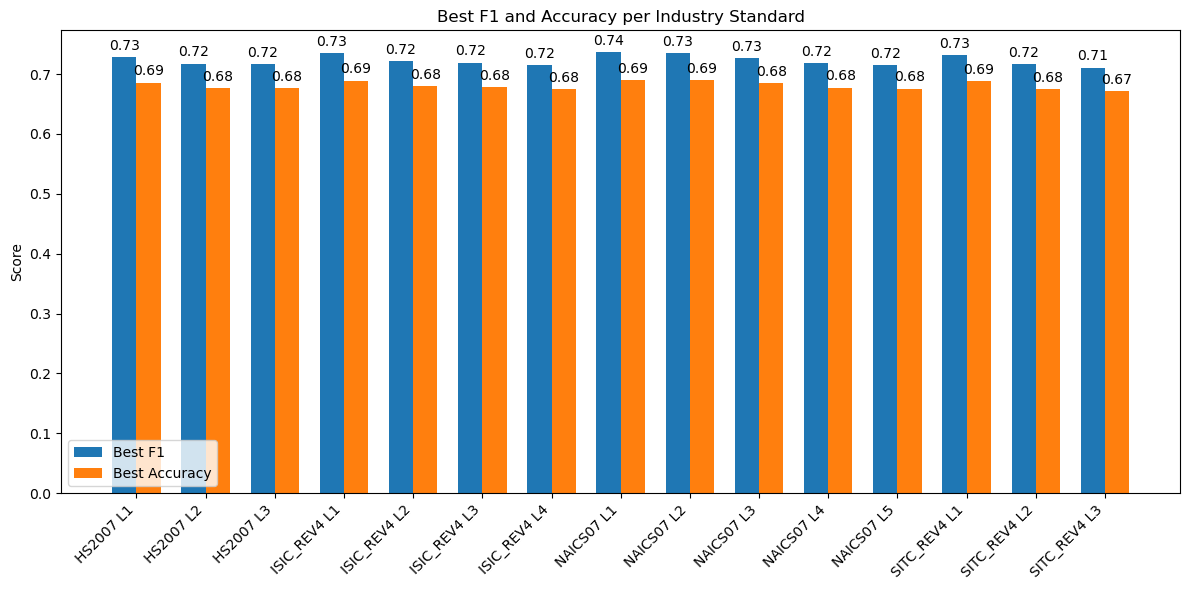

In [10]:
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

# -----------------------
# Assume you already have your big defaultdict called `results`:
# For demonstration, I'll show how to process it assuming it's named `results`.
# -----------------------


# -----------------------
# 1) Extract best F1 and Accuracy per standard + their years
# -----------------------

best_metrics = {}  # { standard: {'best_f1': f1, 'best_f1_years': [], 'best_acc': acc, 'best_acc_years': []} }

for standard, yearly_results in results.items():
    # Find max F1 and max accuracy
    max_f1 = max(item['f1'] for item in yearly_results)
    max_acc = max(item['accuracy'] for item in yearly_results)

    # Find year(s) for these
    best_f1_years = [item['year'] for item in yearly_results if item['f1'] == max_f1]
    best_acc_years = [item['year'] for item in yearly_results if item['accuracy'] == max_acc]

    best_metrics[standard] = {
        'best_f1': max_f1,
        'best_f1_years': best_f1_years,
        'best_acc': max_acc,
        'best_acc_years': best_acc_years
    }

# -----------------------
# 2) Print best F1 & Accuracy + their years
# -----------------------

print("\nBest F1 and Accuracy + years per standard:\n")
for standard, info in best_metrics.items():
    print(f"{standard}:")
    print(f"  Best F1: {info['best_f1']:.4f} (Year(s): {info['best_f1_years']})")
    print(f"  Best Accuracy: {info['best_acc']:.4f} (Year(s): {info['best_acc_years']})")
    print()

# -----------------------
# 3) Prepare data for plotting
# -----------------------

standards = list(best_metrics.keys())
best_f1 = [best_metrics[s]['best_f1'] for s in standards]
best_acc = [best_metrics[s]['best_acc'] for s in standards]

x = np.arange(len(standards))  # positions

# -----------------------
# 4) Plot bar chart (without years)
# -----------------------

width = 0.35  # width of each bar

fig, ax = plt.subplots(figsize=(12, 6))

bars1 = ax.bar(x - width/2, best_f1, width, label='Best F1')
bars2 = ax.bar(x + width/2, best_acc, width, label='Best Accuracy')

ax.set_ylabel('Score')
ax.set_title('Best F1 and Accuracy per Industry Standard')
ax.set_xticks(x)
ax.set_xticklabels(standards, rotation=45, ha='right')
ax.legend()

# Annotate bars
def annotate_bars(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

annotate_bars(bars1)
annotate_bars(bars2)

plt.tight_layout()
plt.show()
